In [2]:
import numpy as np
np.set_printoptions(suppress=True)

import networkx as nx
from sklearn.neighbors import KDTree

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 10)

from udacity_stuff import extract_polygons, load_data

In [3]:
ANCHOR = (37.792480, -122.397450)

In [20]:
def loc2latlon(pos, anchor=(37.792480, -122.397450)):
    """
    local frame to global
    """
    x, y, z = pos
    xa, ya, num, let = utm.from_latlon(*anchor)
    lat, lon = utm.to_latlon(xa+x, ya+y, num, let)
    
    return lat, lon, z

(37.792479999846485, -122.39744997808188, 10)

In [19]:
loc2latlon(-300,400)

(37.79610246480133, -122.40082805691722)

In [4]:
import utm
utm.to_latlon(340000, 5710000, 32, 'U')
# (51.51852098408468, 6.693872395145327)

(51.51842958278862, 6.69387701361587)

In [3]:
def sample_points(data, polygons, n_points=1000, z_range=(5,10)):
    centers = data[:, 0:3]
    sizes = data[:, 3:6]
    
    grid, _, _ = create_grid(data, 5, 2)
    
    #radius_xyz = np.sqrt(np.sum(sizes**2, axis=1)).max()
    radius_xy = np.sqrt(np.sum(sizes[:,0:2]**2, axis=1)).max()

    max_x, max_y, max_z = np.max(centers + sizes, axis=0)
    min_x, min_y, min_z = np.min(centers - sizes, axis=0)

    min_z = max(z_range[0], min_z)
    max_z = min(z_range[1], max_z)

    # sample n_points
    points = np.random.uniform(
        low=[min_x, min_y, min_z],
        high=[max_x, max_y, max_z],
        size=(n_points,3)
        ).astype(np.int)

    tree = KDTree(centers[:,0:2], metric='euclidean')

    good_points = []
    for p in points:
        bad = False
        for n_idx in tree.query_radius([[p[0], p[1]]], r=radius_xy)[0]:
            if polygons[n_idx].contains(p):
                bad = True
                break
        if not bad:
            good_points.append(p)
            
    return np.array(good_points)

# Sampling collision-free points

In [4]:
data = load_data('colliders.csv')
obstacles = extract_polygons(data)
points = sample_points(data, obstacles, 1000, (2,5))
len(points)

620

In [22]:
loc2latlon((400,400,10))

(37.79606176175873, -122.39287755584702, 10)

In [64]:
import copy
from shapely.geometry import Polygon, Point, LineString

def collision(n1, n2, polygons):
    l = LineString([n1, n2])
    for p in polygons:
        if p.crosses(l) and p.height >= min(n1[2], n2[2]):
            return True

def create_graph(points, bf=4, return_tree=False):
    """
    points: Nx3 array of sampled points 
    bf: branching factor
    """
    
    tree = KDTree(points)
    # get nearest neighbors of each point
    dist, nn_idx = tree.query(points, bf+1, return_distance=True)

    # drop the very nearest points (it's the query point itself)
    dist, nn_idx = dist[:,1:], nn_idx[:,1:] 
    
    g = nx.Graph()

    for point, nbrs_idx, dists in zip(points, nn_idx, dist):
        for idx, d in zip(nbrs_idx, dists):
            nbr = points[idx]
            g.add_edge(tuple(point), tuple(nbr), weight=d)
    
    return (g, tree if return_tree else g)

def prune_graph(graph, obstacles, copy_graph=True):
    if copy_graph:
        graph = copy.deepcopy(graph)
        
    for (p1, p2) in list(graph.edges):
        print('edge')
        if collision(p1, p2, polygons=obstacles):
            graph.remove_edge(p1, p2)
            
    return graph

def prune_path(path, polygons):
    pth = np.array(path, copy=True)
    i = 0
    l = len(path)
    idx_to_keep = list(range(l))
    while i<l-2:
        st = path[i]
        while (i<l-2 and not collision(st, path[i+2], polygons)):
            idx_to_keep.remove(i+1)
            i+=1
        i+=1
    return pth[idx_to_keep]


import utm
def latlon2loc(position_global, anchor_global, anchor_local=[0,0]):
    position = position_global
    easting_p, northing_p, _, _ = utm.from_latlon(position[0], position[1])
    easting_a, northing_a, _, _ = utm.from_latlon(anchor_global[0], anchor_global[1])

    lx = easting_p - easting_a
    ly = northing_p - northing_a

    # in case we don't start from map center
    lx -= anchor_local[0]
    ly -= anchor_local[1]

    return lx, ly, position_global[2]

# Creating collision-free graph

In [57]:
points = sample_points(data, obstacles, 100, z_range=(5,10))

In [58]:
graph, kd_tree = create_graph(points, bf=5, return_tree=True)


In [65]:
gp = prune_graph(graph, obstacles, copy_graph=True)

edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge
edge


In [60]:
from concurrent.futures import ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=1) as executor:
    future = executor.submit(prune_graph, graph, obstacles, copy_graph=True)
    path = future.result()

In [7]:
data = load_data('colliders.csv')
obstacles = extract_polygons(data)
np.random.seed(420)
points = sample_points(data, obstacles, 1000, (5,10))
graph, kd_tree = create_graph(points, bf=5, return_tree=True)
pruned_graph = prune_graph(graph, obstacles, copy_graph=True)
# graph = prune_graph(graph, obstacles, copy_graph=False)
len(points)

589

# A* search

In [12]:
# find nodes closest to start and goal

start = (0,0,10)
goal = (400,400,10)

(d1,d2),(s_idx,g_idx) = kd_tree.query([start, goal])

start_node = tuple(*points[s_idx])
goal_node = tuple(*points[g_idx])

assert start_node in graph
assert goal_node in graph
assert d1 < 50
assert d2 < 50

path = nx.algorithms.shortest_paths.astar.astar_path(pruned_graph, start_node, goal_node)
pruned_path = prune_path(path, obstacles)

# Visualize graph

In [13]:
from planning_utils import create_grid
grid, offset_x, offset_y = create_grid(data, 5, 2)

In [14]:
pruned_path.astype(np.int)

array([[ 30, -18,   5],
       [110, 114,   5],
       [273, 306,   8],
       [235, 439,   9],
       [279, 429,   8],
       [393, 401,   5]])

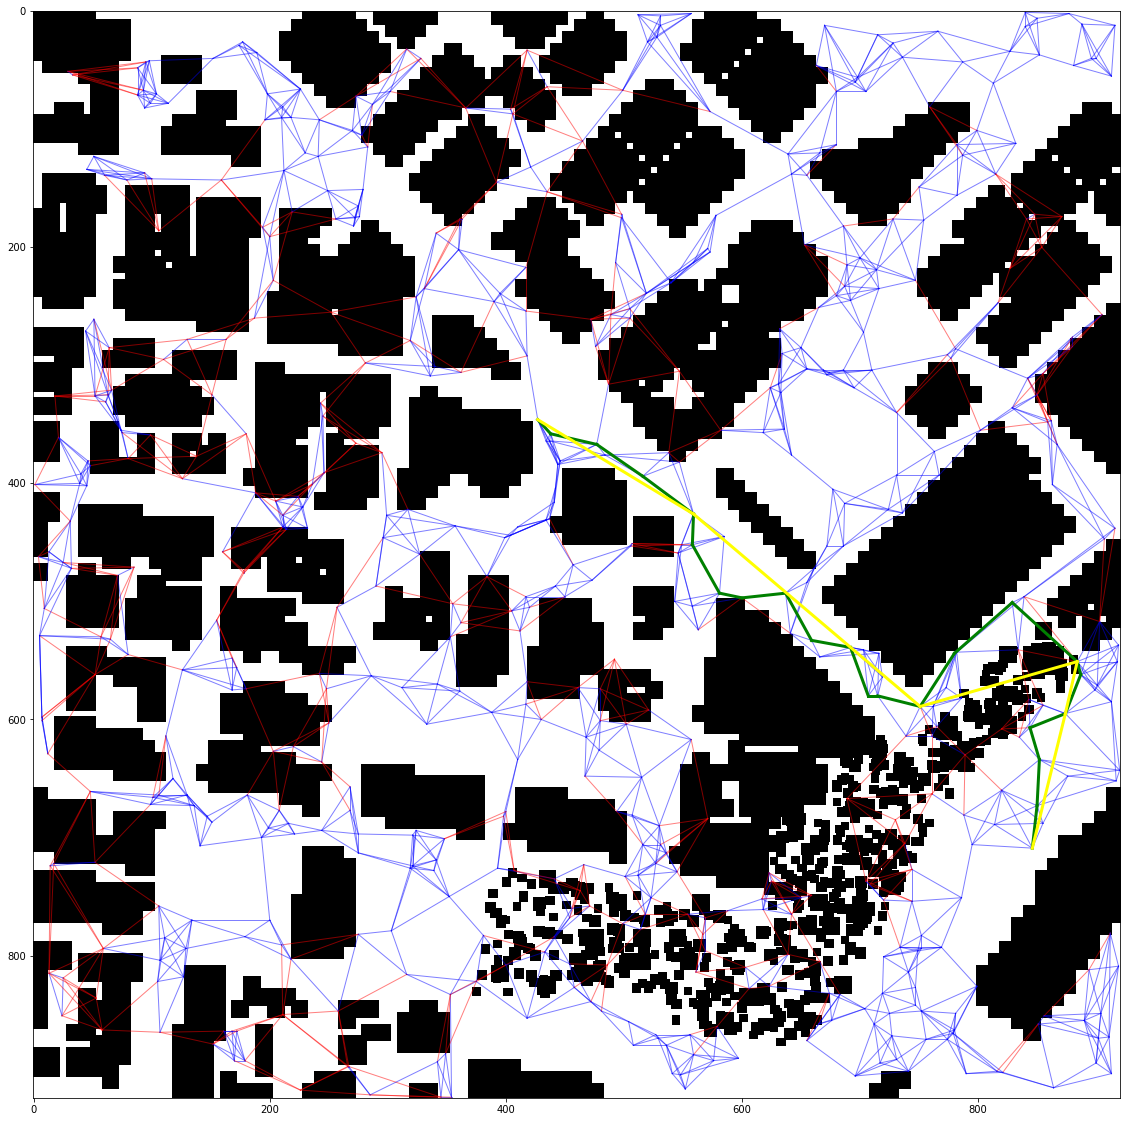

In [16]:
plt.figure(figsize=(20,20))

plt.imshow(grid, cmap='gray_r')

for (n1, n2) in graph.edges:
    
    color = 'blue' if (n1, n2) in pruned_graph.edges else 'red'
    plt.plot([n1[1]-offset_y, n2[1]-offset_y],
             [n1[0]-offset_x, n2[0]-offset_x],
             color,
             linewidth=1,
             alpha=0.5)
    
for i in range(0, len(path)-1):
    plt.plot(
        [path[i+1][1]-offset_y, path[i][1]-offset_y],
        [path[i+1][0]-offset_x, path[i][0]-offset_x],
        'green',
        linewidth=3,
        alpha=1
    )
    
for i in range(0, len(pruned_path)-1):
    plt.plot(
        [pruned_path[i+1][1]-offset_y, pruned_path[i][1]-offset_y],
        [pruned_path[i+1][0]-offset_x, pruned_path[i][0]-offset_x],
        'yellow',
        linewidth=3,
        alpha=1
    )

# Multiple paths

In [39]:
ferry_building = (37.795887, -122.392285, 10)
union_bank = (37.7932283,-122.4006395, 10)

corner1 = (-200, -439, 10)
corner2 = (-210, 470, 10)
corner3 = (599, -439, 10)
corner4 = (599, 470, 10)
trader_joes = (-200, -250, 10)

goals = np.array([
    latlon2loc(ferry_building, anchor_global=ANCHOR),
    trader_joes,
    #latlon2loc(trader_joes, anchor_global=ANCHOR),
    latlon2loc(union_bank, anchor_global=ANCHOR),
    corner1,
    corner2,
    corner3,
    corner4
])

goals = goals.astype(np.int)

# Let's ensure that all goals are in reachable locations

In [35]:
goals_pos[3]

array([116,   6,  10])

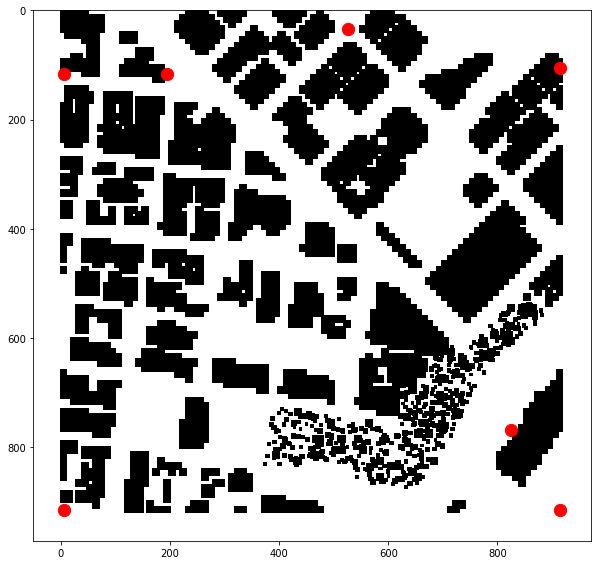

In [40]:
goals_pos = goals - [offset_x, offset_y, 0]
plt.figure(figsize=(10,10))
plt.imshow(grid, cmap='gray_r')
plt.scatter(goals_pos[:,1], goals_pos[:,0], c='red', s=150)

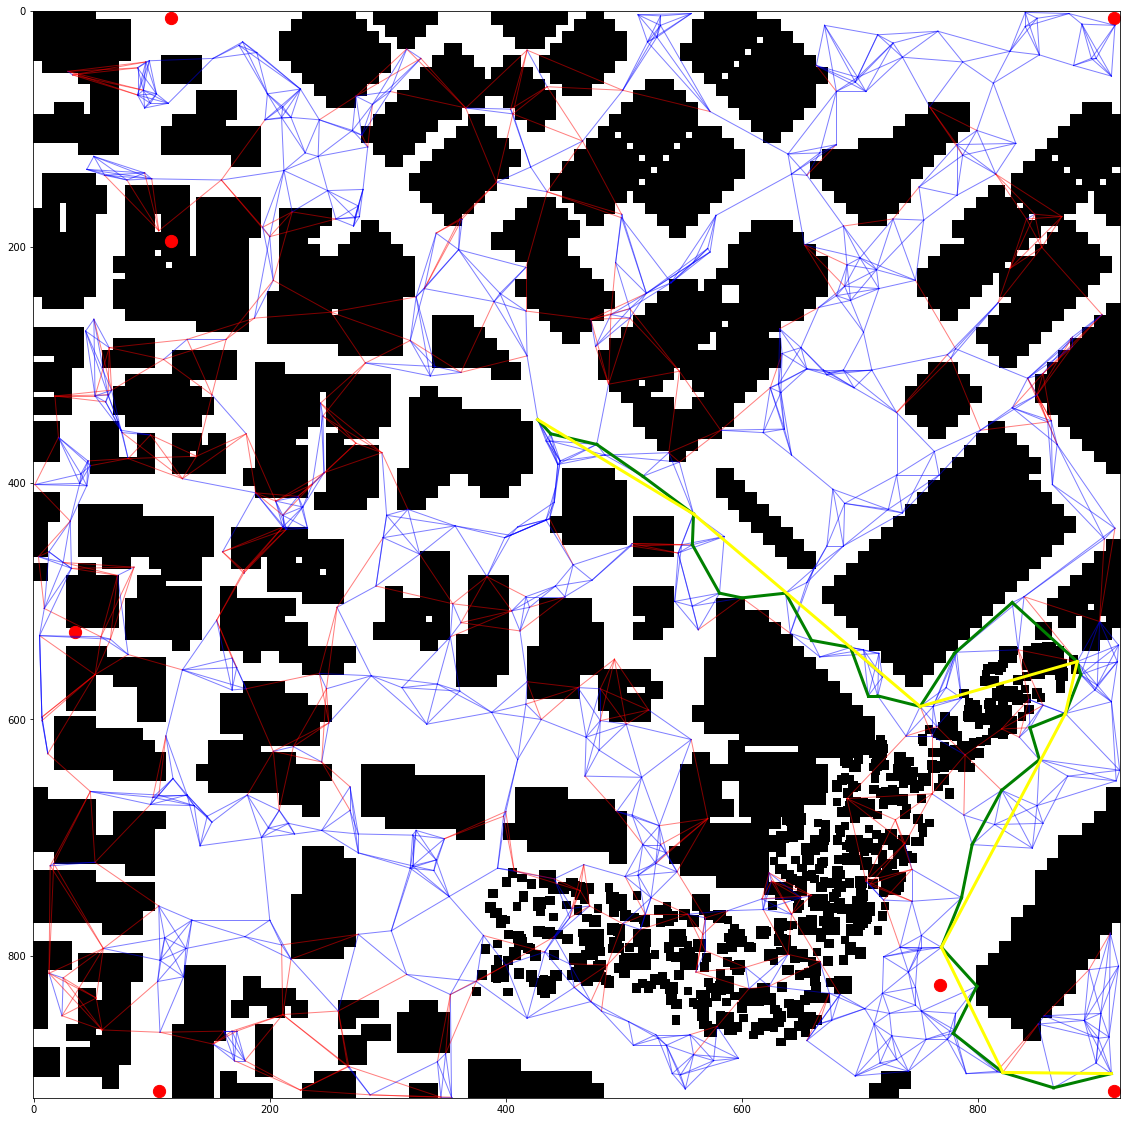

In [41]:
plt.figure(figsize=(20,20))

plt.imshow(grid, cmap='gray_r')

for (n1, n2) in graph.edges:
    
    color = 'blue' if (n1, n2) in pruned_graph.edges else 'red'
    plt.plot([n1[1]-offset_y, n2[1]-offset_y],
             [n1[0]-offset_x, n2[0]-offset_x],
             color,
             linewidth=1,
             alpha=0.5)
    
for i in range(0, len(path)-1):
    plt.plot(
        [path[i+1][1]-offset_y, path[i][1]-offset_y],
        [path[i+1][0]-offset_x, path[i][0]-offset_x],
        'green',
        linewidth=3,
        alpha=1
    )
    
for i in range(0, len(pruned_path)-1):
    plt.plot(
        [pruned_path[i+1][1]-offset_y, pruned_path[i][1]-offset_y],
        [pruned_path[i+1][0]-offset_x, pruned_path[i][0]-offset_x],
        'yellow',
        linewidth=3,
        alpha=1
    )
    
plt.scatter(goals_pos[:,0], goals_pos[:,1], c='red', s=150)

In [24]:
goals[1] - [offset_x, offset_y, 0]

array([208, 117,  10])

In [49]:
paths = []
pruned_paths = []
for goal in goals:
    start = (0,0,5)
    
    (d1,d2),(s_idx,g_idx) = kd_tree.query([start, goal])

    start_node = tuple(*points[s_idx])
    goal_node = tuple(*points[g_idx])

    try:
        path = nx.algorithms.shortest_paths.astar.astar_path(pruned_graph, start_node, goal_node)
        pruned_path = prune_path(path, obstacles)
        paths.append(path)
        pruned_paths.append(pruned_path)
    except nx.NetworkXNoPath:
        print("path not found")

path not found
path not found
path not found


# Plot path to different goals

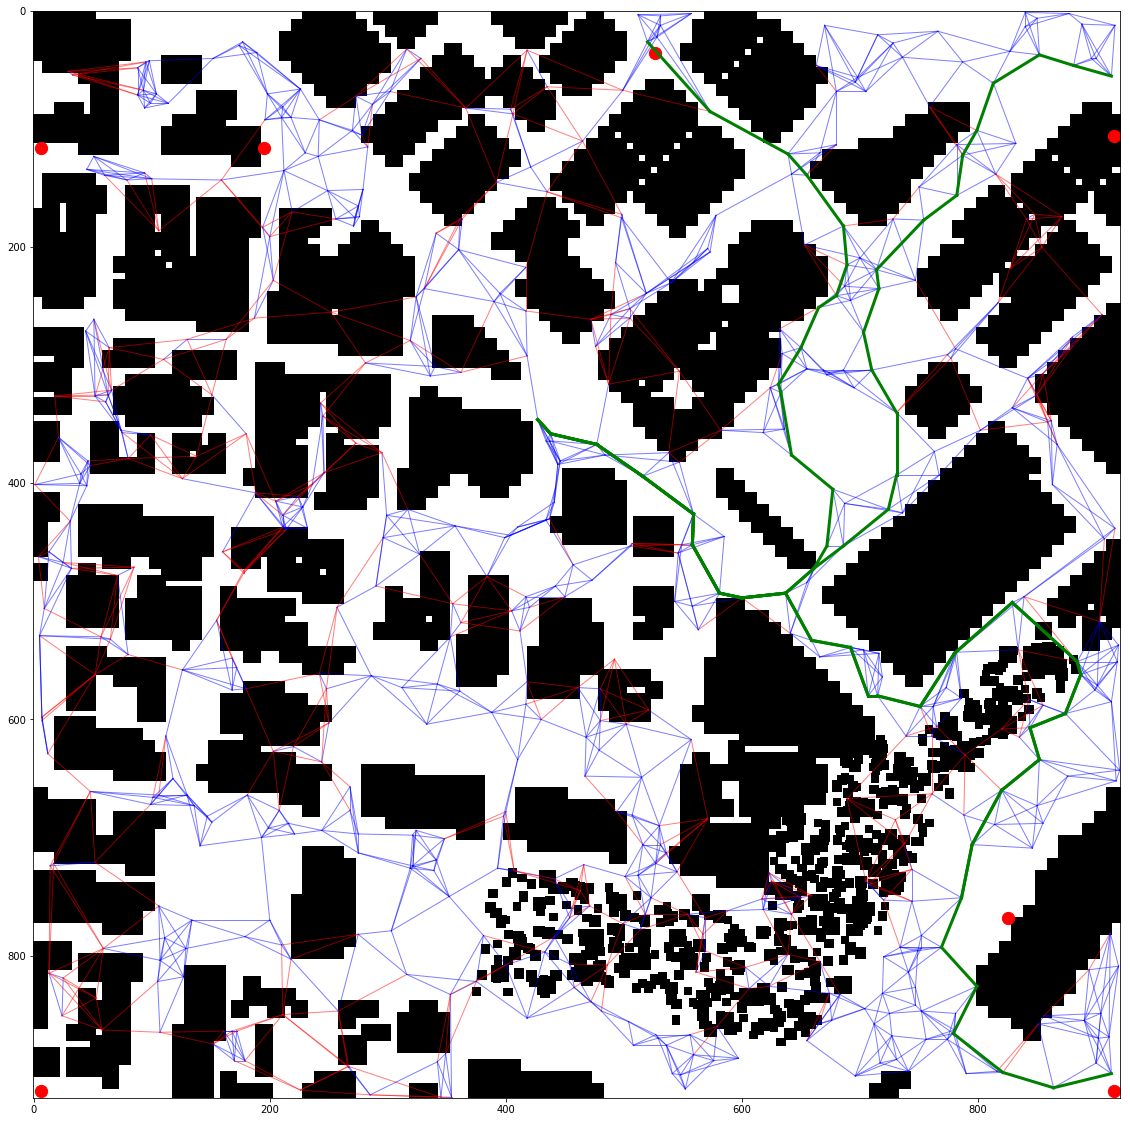

In [43]:
plt.figure(figsize=(20,20))

plt.imshow(grid, cmap='gray_r')

for (n1, n2) in graph.edges:
    
    color = 'blue' if (n1, n2) in pruned_graph.edges else 'red'
    plt.plot([n1[1]-offset_y, n2[1]-offset_y],
             [n1[0]-offset_x, n2[0]-offset_x],
             color,
             linewidth=1,
             alpha=0.5)
    
for path in paths:
    for i in range(0, len(path)-1):
        plt.plot(
            [path[i+1][1]-offset_y, path[i][1]-offset_y],
            [path[i+1][0]-offset_x, path[i][0]-offset_x],
            'green',
            linewidth=3,
            alpha=1
        )

    
plt.scatter(goals_pos[:,1], goals_pos[:,0], c='red', s=150)

# find paths for all the goals
(if reachable)

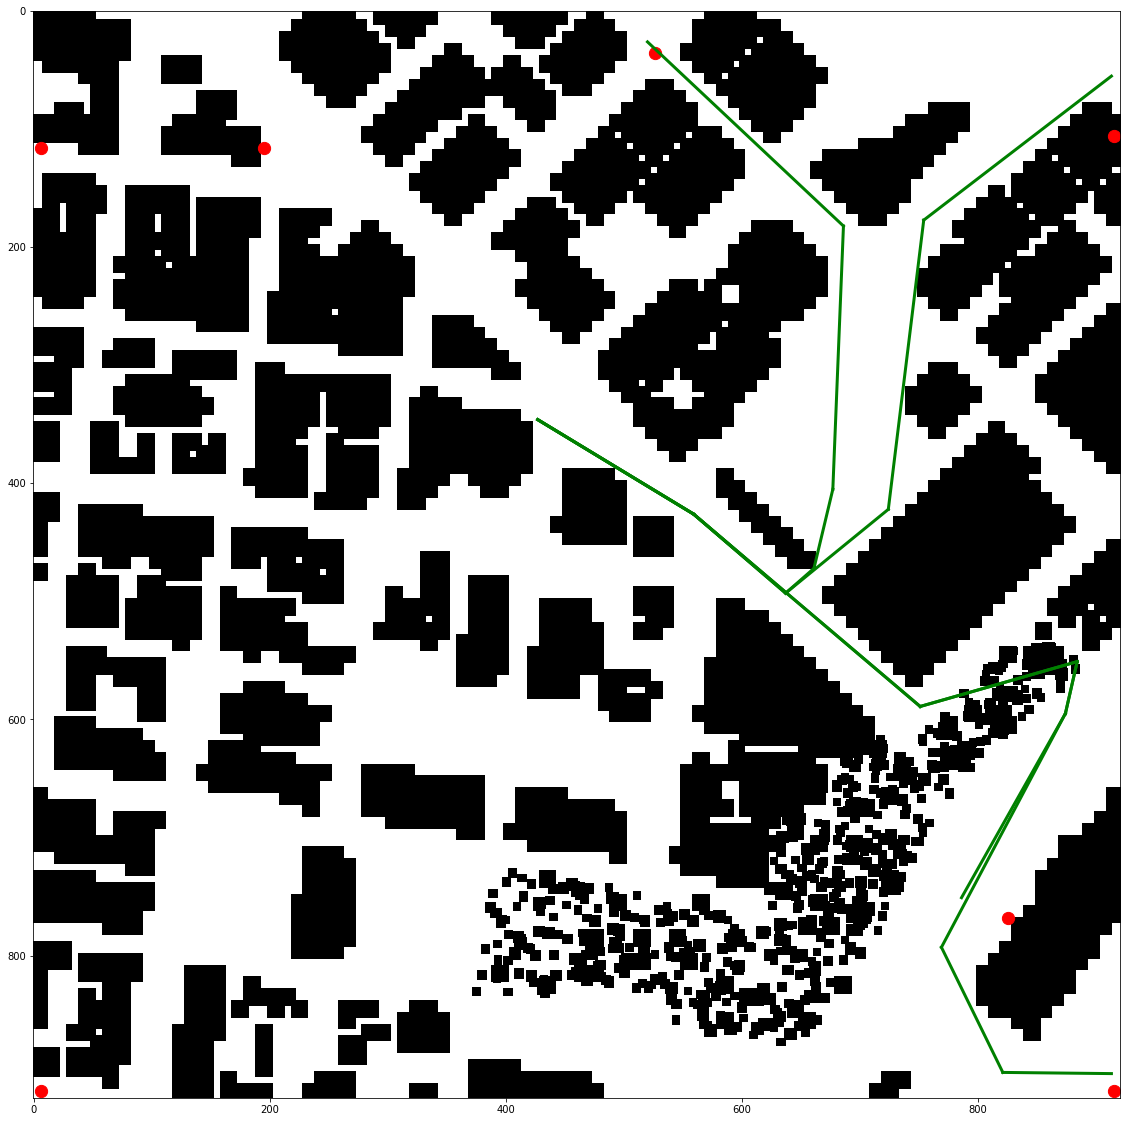

In [50]:
plt.figure(figsize=(20,20))

plt.imshow(grid, cmap='gray_r')

    
for path in pruned_paths:
    for i in range(0, len(path)-1):
        plt.plot(
            [path[i+1][1]-offset_y, path[i][1]-offset_y],
            [path[i+1][0]-offset_x, path[i][0]-offset_x],
            'green',
            linewidth=3,
            alpha=1
        )

    
plt.scatter(goals_pos[:,1], goals_pos[:,0], c='red', s=150)

In [56]:
pruned_paths

[array([[ 30, -18,   5],
        [110, 114,   5],
        [273, 306,   8],
        [235, 439,   9],
        [279, 429,   8],
        [435, 341,   8]]), array([[  30,  -18,    5],
        [ 110,  114,    5],
        [ 177,  192,    6],
        [ 156,  216,    8],
        [  89,  232,    7],
        [-134,  241,    9],
        [-290,   75,    6]]), array([[  30,  -18,    5],
        [ 110,  114,    5],
        [ 177,  192,    6],
        [ 106,  279,    5],
        [-139,  309,    9],
        [-261,  468,    5]]), array([[ 30, -18,   5],
        [110, 114,   5],
        [273, 306,   8],
        [235, 439,   9],
        [279, 429,   8],
        [477, 324,   6],
        [583, 376,   7],
        [584, 468,   8]])]

In [51]:
pruned_paths

[array([[ 30, -18,   5],
        [110, 114,   5],
        [273, 306,   8],
        [235, 439,   9],
        [279, 429,   8],
        [435, 341,   8]]), array([[  30,  -18,    5],
        [ 110,  114,    5],
        [ 177,  192,    6],
        [ 156,  216,    8],
        [  89,  232,    7],
        [-134,  241,    9],
        [-290,   75,    6]]), array([[  30,  -18,    5],
        [ 110,  114,    5],
        [ 177,  192,    6],
        [ 106,  279,    5],
        [-139,  309,    9],
        [-261,  468,    5]]), array([[ 30, -18,   5],
        [110, 114,   5],
        [273, 306,   8],
        [235, 439,   9],
        [279, 429,   8],
        [477, 324,   6],
        [583, 376,   7],
        [584, 468,   8]])]